# RNN LSTM

## Univariate using manual scaling

Keras 2.2.5
Tensorflow 1.9

In [2]:
import numpy as np
import pandas as pd

from math import sqrt
import datetime as dt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler

from keras import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model

from sklearn.metrics import mean_squared_error

import os.path

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


Using TensorFlow backend.
C:\Users\xuldr\anaconda3\envs\capstone\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\xuldr\anaconda3\envs\capstone\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\xuldr\anaconda3\envs\capstone\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\xuldr\anaconda3\envs\capstone

The Following function is building the training sequence

In [24]:
def BuildTrain(df, startDate,endDate, X_previous, y_previous):
    X = []
    y =[]
    lookback = 40 # 40 times 15 minutes -> 10 Hours
    
    data = df[(df.Datetime>= startDate) & (df.Datetime< endDate)]

    # Col2: CLOSE, col3: Volume, col4: NewsUSD, col5: News EUR, col6: USA30.Idx,col7: EUS50Idx
    input_feature= data.iloc[:,2].values

    input_data = input_feature

    for i in range(len(data)-lookback-4):
        t=[]
        for j in range(0,lookback):
            t.append(input_data[[(i+j)]])
        X.append(t)
        u = []
        for k in range(4):
            u.append(input_data[i+ lookback + k])
        y.append(u)
    # Transforming dataframe in numpy arrays
    X, y = np.array(X), np.array(y)  
    X = X.reshape(X.shape[0],lookback, 1)

    if len(X_previous)!=0:
        X = np.concatenate((X_previous, X))
        y = np.concatenate((y_previous, y))
    return(X,y)

In [25]:
df = pd.read_csv('./data/EURUSD_Wfeatures.csv', index_col = 0)
df.drop(columns={'USA30.IDXUSD_VOL','EUS.IDXEUR_VOL'}, axis = 1, inplace = True)
df.drop(columns={'OPEN','HIGH','LOW'}, axis = 1, inplace = True)

# Converting the index as date
df.Datetime = pd.to_datetime(df['Datetime'])
df.describe()

,index,CLOSE,Volume,News_USD,News_EUR,USA30.IDXUSD_CLOSE,EUS.IDXEUR_CLOSE
count,11548.000000,11548.000000,11548.000000,11548.000000,11548.000000,11548.000000,11548.000000
mean,5749.741081,1.104788,1076.387125,0.038712,0.028742,28383.878947,3729.240052
std,3333.352222,0.009943,1684.913242,0.144919,0.128639,744.661505,83.713354
min,0.000000,1.078440,0.000000,0.000000,0.000000,24712.020000,3283.830000
25%,2862.750000,1.101480,0.000000,0.000000,0.000000,27940.330000,3695.131000
50%,5749.500000,1.106530,588.660000,0.000000,0.000000,28474.330000,3742.431000
75%,8636.250000,1.111880,1596.100000,0.000000,0.000000,28978.800000,3780.460000
max,11523.000000,1.123820,43516.811300,1.882712,3.378899,29569.600000,3865.120000


Removing the data that will be used for testing

In [26]:
startDate = dt.datetime(2019,11,3,17,0,0)
endDate = dt.datetime(2020,1,31,16,45,0) # Scaling on Train only

df = df[(df.Datetime>= startDate) & (df.Datetime< endDate)]

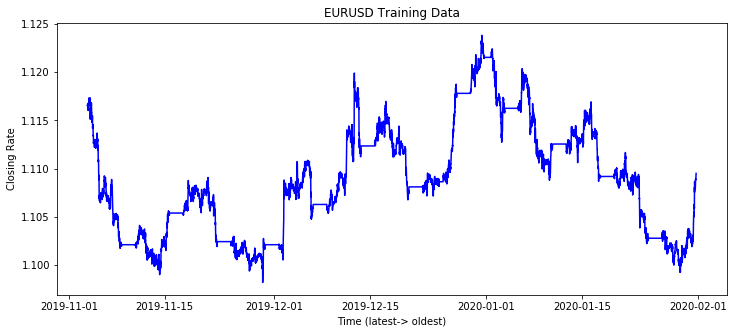

In [27]:
plt.figure(figsize=(12,5))
plt.plot(df.Datetime,df.CLOSE, color='blue')
plt.title("EURUSD Training Data")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Closing Rate")
plt.show()

### Manual Scaling

Here manual scaling is applied. As currencies don't vary that much and as I need to prevent the adverse effects of having the test data going beyond the limits
- 0 will be 10% below the min value off the training sequence
- 1 will be 10% above the max value


In [28]:
Exp_var = 0.1

Exp_min = df.CLOSE.min()*(1 - Exp_var)
Exp_max = df.CLOSE.max()*(1 + Exp_var)
scale = Exp_max - Exp_min
df.CLOSE = (df.CLOSE - Exp_min) / (Exp_max -Exp_min)
df.describe()

,index,CLOSE,Volume,News_USD,News_EUR,USA30.IDXUSD_CLOSE,EUS.IDXEUR_CLOSE
count,8543.000000,8543.000000,8543.000000,8543.000000,8543.000000,8543.000000,8543.000000
mean,4439.000000,0.485676,981.421517,0.043070,0.033221,28335.751332,3732.356262
std,2466.296008,0.022693,1464.379535,0.153885,0.140947,517.407510,44.766309
min,168.000000,0.443181,0.000000,0.000000,0.000000,27324.831000,3605.531000
25%,2303.500000,0.462612,0.000000,0.000000,0.000000,27906.530000,3697.775000
50%,4439.000000,0.483858,610.490000,0.000000,0.000000,28269.031000,3737.831000
75%,6574.500000,0.501049,1542.145000,0.000000,0.000000,28695.315000,3771.730000
max,8710.000000,0.546488,43516.811300,1.882712,3.378899,29399.110000,3812.400000


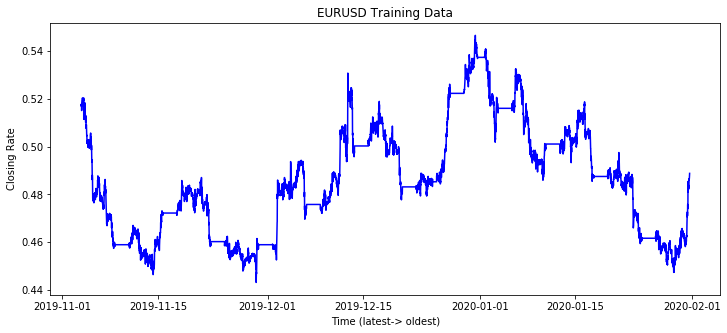

In [29]:
plt.figure(figsize=(12,5))
plt.plot(df.Datetime,df.CLOSE, color='blue')
plt.title("EURUSD Training Data")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Closing Rate")
plt.show()

Every week of trading is added manually, Christmas and New Year's week were not added.

In [30]:
X = []
y = []

startDate = dt.datetime(2019,11,3,17,0,0)
endDate = dt.datetime(2019,11,8,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2019,11,10,17,0,0)
endDate = dt.datetime(2019,11,15,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2019,11,17,17,0,0)
endDate = dt.datetime(2019,11,22,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2019,11,24,17,0,0)
endDate = dt.datetime(2019,11,29,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2019,12,1,17,0,0)
endDate = dt.datetime(2019,12,6,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2019,12,8,17,0,0)
endDate = dt.datetime(2019,12,13,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2019,12,15,17,0,0)
endDate = dt.datetime(2019,12,20,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2020,1,5,17,0,0)
endDate = dt.datetime(2020,1,10,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2020,1,12,17,0,0)
endDate = dt.datetime(2020,1,17,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2020,1,19,17,0,0)
endDate = dt.datetime(2020,1,24,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

startDate = dt.datetime(2020,1,26,17,0,0)
endDate = dt.datetime(2020,1,31,16,45,0)
X, y = BuildTrain(df, startDate, endDate, X, y)

print(X.shape)
print(y.shape)

(4785, 40, 1)
(4785, 4)


# Model training

If required of if the h5 file doesn't exist

In [31]:
retrain = False
h5File =  '../../capstonedata/Results_LSTMU/Univariate-LSTM-manual_scaling.h5'

In [32]:
if ((not os.path.exists(h5File)) | (retrain==True)):
    print("Retraining the model")
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],1)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=4))
    model.summary()
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=20, batch_size=32)
    
    model.save("Univariate_LSTM_ManualScaling_Jupyter.h5")
    
else:
    print("Loading the Model")
    model = load_model("Univariate_LSTM_ManualScaling_Jupyter.h5")

Retraining the model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 40, 30)            3840      
_________________________________________________________________
lstm_5 (LSTM)                (None, 40, 30)            7320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 124       
Total params: 18,604
Trainable params: 18,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4785/4785 [==============================] - 96s 20ms/step - loss: 0.0127
Epoch 2/20
4785/4785 [==============================] - 112s 23ms/step - loss: 1.3626e-04
Epoch 3/20
4785/4785 [==============================

Save model

 Reloading the unscaled data 

In [33]:
dtst = pd.read_csv('../../capstonedata/MarketData-Dukas/EURUSD_Wfeatures.csv', index_col = 0)
dtst.drop(columns={'OPEN','HIGH','LOW'}, axis = 1, inplace = True)

# Converting the index as date
dtst.Datetime = pd.to_datetime(dtst['Datetime'])
dtst.head(4)

,index,Datetime,CLOSE,Volume,News_USD,News_EUR,USA30.IDXUSD_CLOSE,USA30.IDXUSD_VOL,EUS.IDXEUR_CLOSE,EUS.IDXEUR_VOL
0,0,2019-11-02 00:00:00,1.11675,0.0,0.0,0.0,27324.831,0.0,3631.631,0.0
1,1,2019-11-02 00:15:00,1.11675,0.0,0.0,0.0,27324.831,0.0,3631.631,0.0
2,2,2019-11-02 00:30:00,1.11675,0.0,0.0,0.0,27324.831,0.0,3631.631,0.0
3,3,2019-11-02 00:45:00,1.11675,0.0,0.0,0.0,27324.831,0.0,3631.631,0.0


In [34]:
# Dropping unsused columns
dtst.drop(columns={'Volume','News_USD','News_EUR','USA30.IDXUSD_CLOSE','EUS.IDXEUR_CLOSE','USA30.IDXUSD_VOL','EUS.IDXEUR_VOL'}, axis = 1, inplace = True)

Transforming the data with custom scaling

In [35]:
dtst.CLOSE = (dtst.CLOSE - Exp_min) / scale 

Selecting only the 4 weeks of February 2020

In [36]:
startDate = dt.datetime(2020,2,2,17,0,0)
endDate = dt.datetime(2020,2,29,16,45,0)

dtst = dtst[(dtst.Datetime>= startDate) & (dtst.Datetime< endDate)]

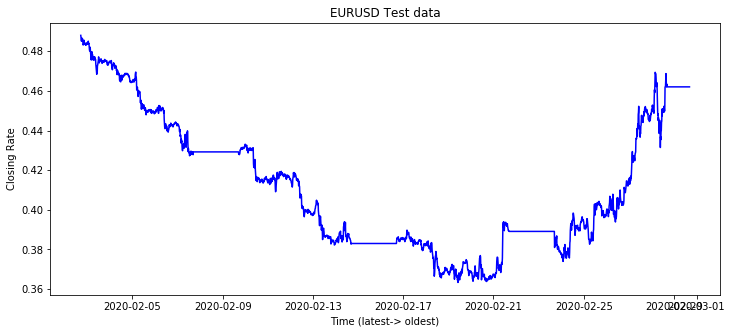

In [37]:
plt.figure(figsize=(12,5))
plt.plot(dtst.Datetime,dtst.CLOSE, color='blue')
plt.title("EURUSD Test data")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Closing Rate")
plt.show()

Test function,returns a dataframe containing the results

In [38]:
def lstm_test(df,startDate):
    endDate = startDate + timedelta(hours = 10)
    X = df[(df.Datetime>= startDate) & (df.Datetime< endDate)]
    y = df[(df.Datetime>= endDate) & (df.Datetime< (endDate + timedelta(hours = 1)))]
    
    last_train = X.CLOSE.tail(1).values[0]
 
    y = y['CLOSE']
    
    X_test = np.array(X)
    X_test = X_test[:,2:4]
    X_test = X_test.reshape(1,40, 1)
    
    predicted_value= model.predict(X_test)
    predicted_value = predicted_value.reshape(4,1)
       
    ltrn = last_train  * scale + Exp_min
    pred = predicted_value * scale + Exp_min
    test = np.array(y) * scale + Exp_min

    rmse = sqrt(mean_squared_error(test,pred))
    mape = np.mean(np.abs((test-pred) / test)) *100
    
    e0 = (pred[0] - test[0])/test[0] *100
    e1 = (pred[1] - test[1])/test[1] *100
    e2 = (pred[2] - test[2])/test[2] *100
    e3 = (pred[3] - test[3])/test[3] *100
    
    t0 = ((test[0] - ltrn ) > 0) == (( pred[0] - ltrn) > 0)
    t1 = ((test[1] - test[0]) > 0 ) == ((pred[1] - pred[0]) > 0 )
    t2 = ((test[2] - test[1]) > 0 ) == ((pred[2]- pred[1]) > 0 )
    t3 = ((test[3] - test[2]) > 0 ) == ((pred[3] - pred[2]) > 0 )
    
    ot1 = ((test[1] - ltrn) > 0 ) == ((pred[1] - ltrn) > 0 )
    ot2 = ((test[2] - ltrn) > 0 ) == ((pred[2]- ltrn) > 0 )
    ot3 = ((test[3] - ltrn) > 0 ) == ((pred[3] - ltrn) > 0 )
    
    #print(ltrn,pred[0])
    ldict = {'RMSE':rmse,'MAPE':mape, 'trend01':t0, 'trend12':t1, 'trend23':t2, 'trend34':t3, 'otrend02': ot1, 'otrend03': ot2, 'otrend04': ot3,
            'Errorpc0': e0,'Errorpc1':e1,'Errorpc2':e2,'Errorpc3':e3}
    results = pd.DataFrame(ldict)
    #print(t0)
    #print("lastT:",round(ltrn,5), "test0: ",test[0], "pred0",pred[0], "trend:",t0)
    return(results)

In [39]:
def trend(res):
    print("Trend lastX 1st pred",results.trend01[results.trend01 == True].count()/results.trend01.count())
    print("Trend 1st/2nd pred",results.trend12[results.trend12 == True].count()/results.trend12.count())
    print("Trend 2st/3nd pred",results.trend23[results.trend23 == True].count()/results.trend23.count())
    print("Trend 3st/4nd pred",results.trend34[results.trend34 == True].count()/results.trend34.count())
    print()
    print("Trend from the last training point to the Nth predicted point")
    print("2nd pred",results.otrend02[results.otrend02 == True].count()/results.otrend02.count())
    print("3nd pred",results.otrend03[results.otrend03 == True].count()/results.otrend03.count())
    print("4nd pred",results.otrend04[results.otrend04 == True].count()/results.otrend04.count())

Testing every hour from Monday 3am to Friday 4pm (one hour before the market closes on Friday 5pm)

The test starts on Monday morning at 3am, 10 hours after the market opens at 5pm on Sunday

In [40]:
results = pd.DataFrame()

for t in range(109):
    Stime = dt.datetime(2020,2,3,3,0,0) + timedelta(hours = (t))
    results = results.append(lstm_test(dtst,Stime))

#results = pd.DataFrame()

for t in range(109):
    Stime = dt.datetime(2020,2,10,3,0,0) + timedelta(hours = (t))
    results = results.append(lstm_test(dtst,Stime))
    
#trend(results)   
#results = pd.DataFrame()

for t in range(109):
    Stime = dt.datetime(2020,2,17,3,0,0) + timedelta(hours = (t))
    results = results.append(lstm_test(dtst,Stime))
    
#trend(results)
#results = pd.DataFrame()

for t in range(109):
    Stime = dt.datetime(2020,2,24,3,0,0) + timedelta(hours = (t))
    results = results.append(lstm_test(dtst,Stime))

trend(results)

Trend lastX 1st pred 0.42201834862385323
Trend 1st/2nd pred 0.48394495412844035
Trend 2st/3nd pred 0.45871559633027525
Trend 3st/4nd pred 0.44495412844036697

Trend from the last training point to the Nth predicted point
2nd pred 0.4426605504587156
3nd pred 0.4541284403669725
4nd pred 0.44036697247706424


#### Trend prediction is very poor.

## Error Distribution

Now, let's look at how far the predictions are from the real datapoints.

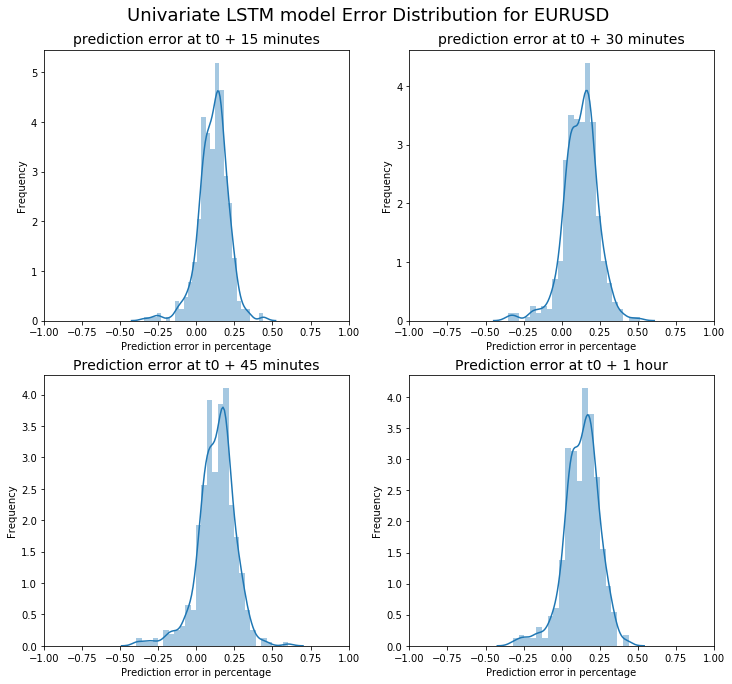

In [42]:
fig = plt.figure(figsize=(12,6))
plt.suptitle("Univariate LSTM model Error Distribution for EURUSD", size=18)
plt.subplots_adjust(left=None, bottom=-0.5, right=None, top=None, wspace=None, hspace=None)
ax1 = fig.add_subplot(221)
ax1.set_xlim([-1, 1])
sns.distplot(results['Errorpc0'])
plt.ylabel("Frequency")
plt.xlabel("Prediction error in percentage")
plt.title("prediction error at t0 + 15 minutes",size=14)

ax2 = fig.add_subplot(222)
ax2.set_xlim([-1, 1])
sns.distplot(results['Errorpc1'])
plt.ylabel("Frequency")
plt.xlabel("Prediction error in percentage")
plt.title("prediction error at t0 + 30 minutes",size=14)

ax3 = fig.add_subplot(223)
ax3.set_xlim([-1, 1])
sns.distplot(results['Errorpc2'])
plt.ylabel("Frequency")
plt.xlabel("Prediction error in percentage")
plt.title("Prediction error at t0 + 45 minutes",size=14)

ax4 = fig.add_subplot(224)
ax4.set_xlim([-1, 1])
sns.distplot(results['Errorpc3'])
plt.ylabel("Frequency")
plt.xlabel("Prediction error in percentage")
plt.title("Prediction error at t0 + 1 hour",size=14)

plt.savefig("LSTM_error_distribution.png")

plt.show()


Text(0.5, 1.0, 'RMSE')

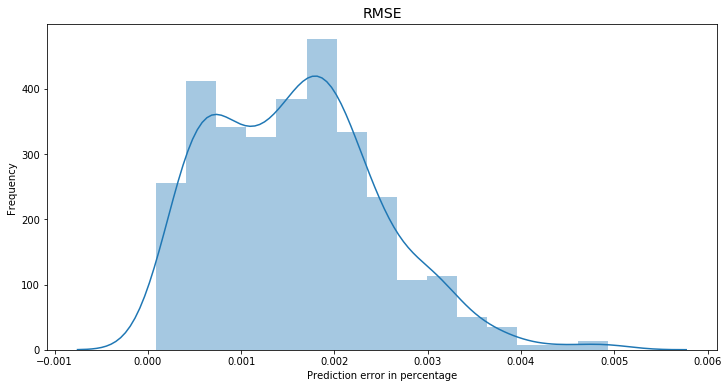

In [43]:
fig = plt.figure(figsize=(12,6))

sns.distplot(results['RMSE'])
plt.ylabel("Frequency")
plt.xlabel("Prediction error in percentage")
plt.title("RMSE",size=14)


In [44]:
results['RMSE'].mean()

0.00158643087095738

Results are pretty poor, other configuration were tried without a better accuracy.